# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 848.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 186
The number of columns: 494


**Imports**

Import all modules necessary for this Jupyter Notebook


In [3]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import datasets as ds

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Basic Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


**Definitions applied in this Jupyter Notebook**

In [4]:
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


**Data Visualization**

In [ ]:
# Code for data visualization

**PRE PROCESSING**

Pre processing contains the following: ...

In [26]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold

# Pre processing
#
# Splitting
df_data = pd.DataFrame(data)
X = df_data.iloc[:, 1:]  # Feature set
y = df_data.iloc[:, :1]  # Classification Benign/Malignant

# Change classification (Benign/Malignant) to binary values
y['label'] = y.replace({'benign': 0, 'malignant': 1})

# Stratified K-Fold Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Splitting data in Test and Train set
for train_index, test_index in skf.split(X, y):
    X_pre_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_pre_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Splitting data in Train and validation set
for train_index, test_index in skf.split(X_pre_train, y_pre_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

# print(y_train)
# print(f'The number of samples: {len(y_train)}')
# print(f'test{y_test}')
# print(f'The number of samples: {len(y_test)}')
# print(f'val{y_val}')
# print(f'The number of samples: {len(y_val)}')


<ipython-input-26-fcfbe0828860>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label'] = y.replace({'benign': 0, 'malignant': 1})


**Scaling**

In [30]:
# Scaling

# # General packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# import seaborn

# # Classifiers
# from sklearn import model_selection
# from sklearn import metrics
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import svm

# from sklearn import decomposition

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# # Feature selection
# # Create the RFE object and compute a cross-validated score.
# svc = svm.SVC(kernel="linear")

# # classifications
# rfecv = feature_selection.RFECV(
#     estimator=svc, step=1,
#     cv=model_selection.StratifiedKFold(4),
#     scoring='roc_auc')
# rfecv.fit(X, y)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
# plt.show()

# Perform a PCA
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_train_list = y_train['label'].tolist()
print(y_train_list)

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Classifiers

**Basic Classifiers**

Number of mislabeled points out of a total 120 points : 59


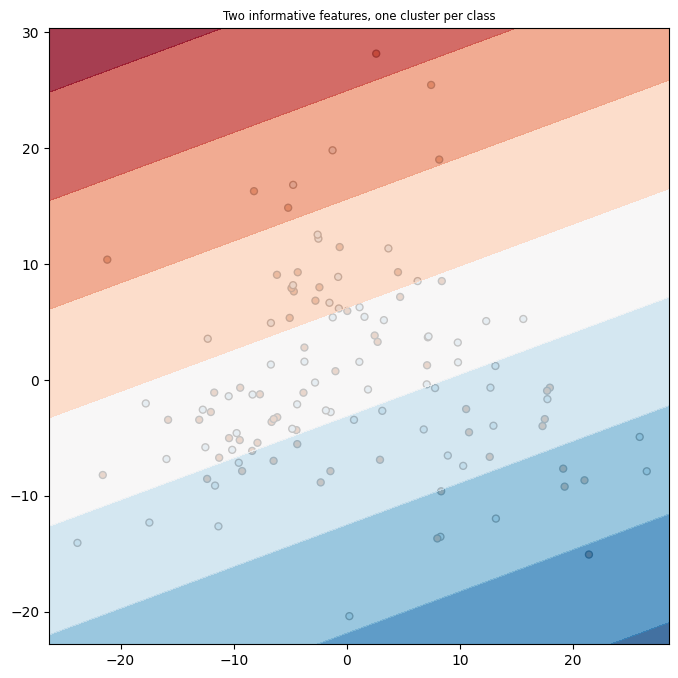

In [7]:
# # General packages
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# from sklearn import metrics

# # Metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# # Basic Classifiers
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

# Linear classifier
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative features, one cluster per class",
             fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train_list,
           s=25, edgecolor='k', cmap=plt.cm.Paired)
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train_list)
y_pred = lda.predict(X_train_pca)
colorplot(lda, ax, X_train_pca[:, 0], X_train_pca[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train_pca.shape[0], (y_train_list != y_pred).sum()))


**Basic classifiers: Gaussian, LDA, QDA, Logistic regression, SDG,  Simple KNN & Decision Tree**

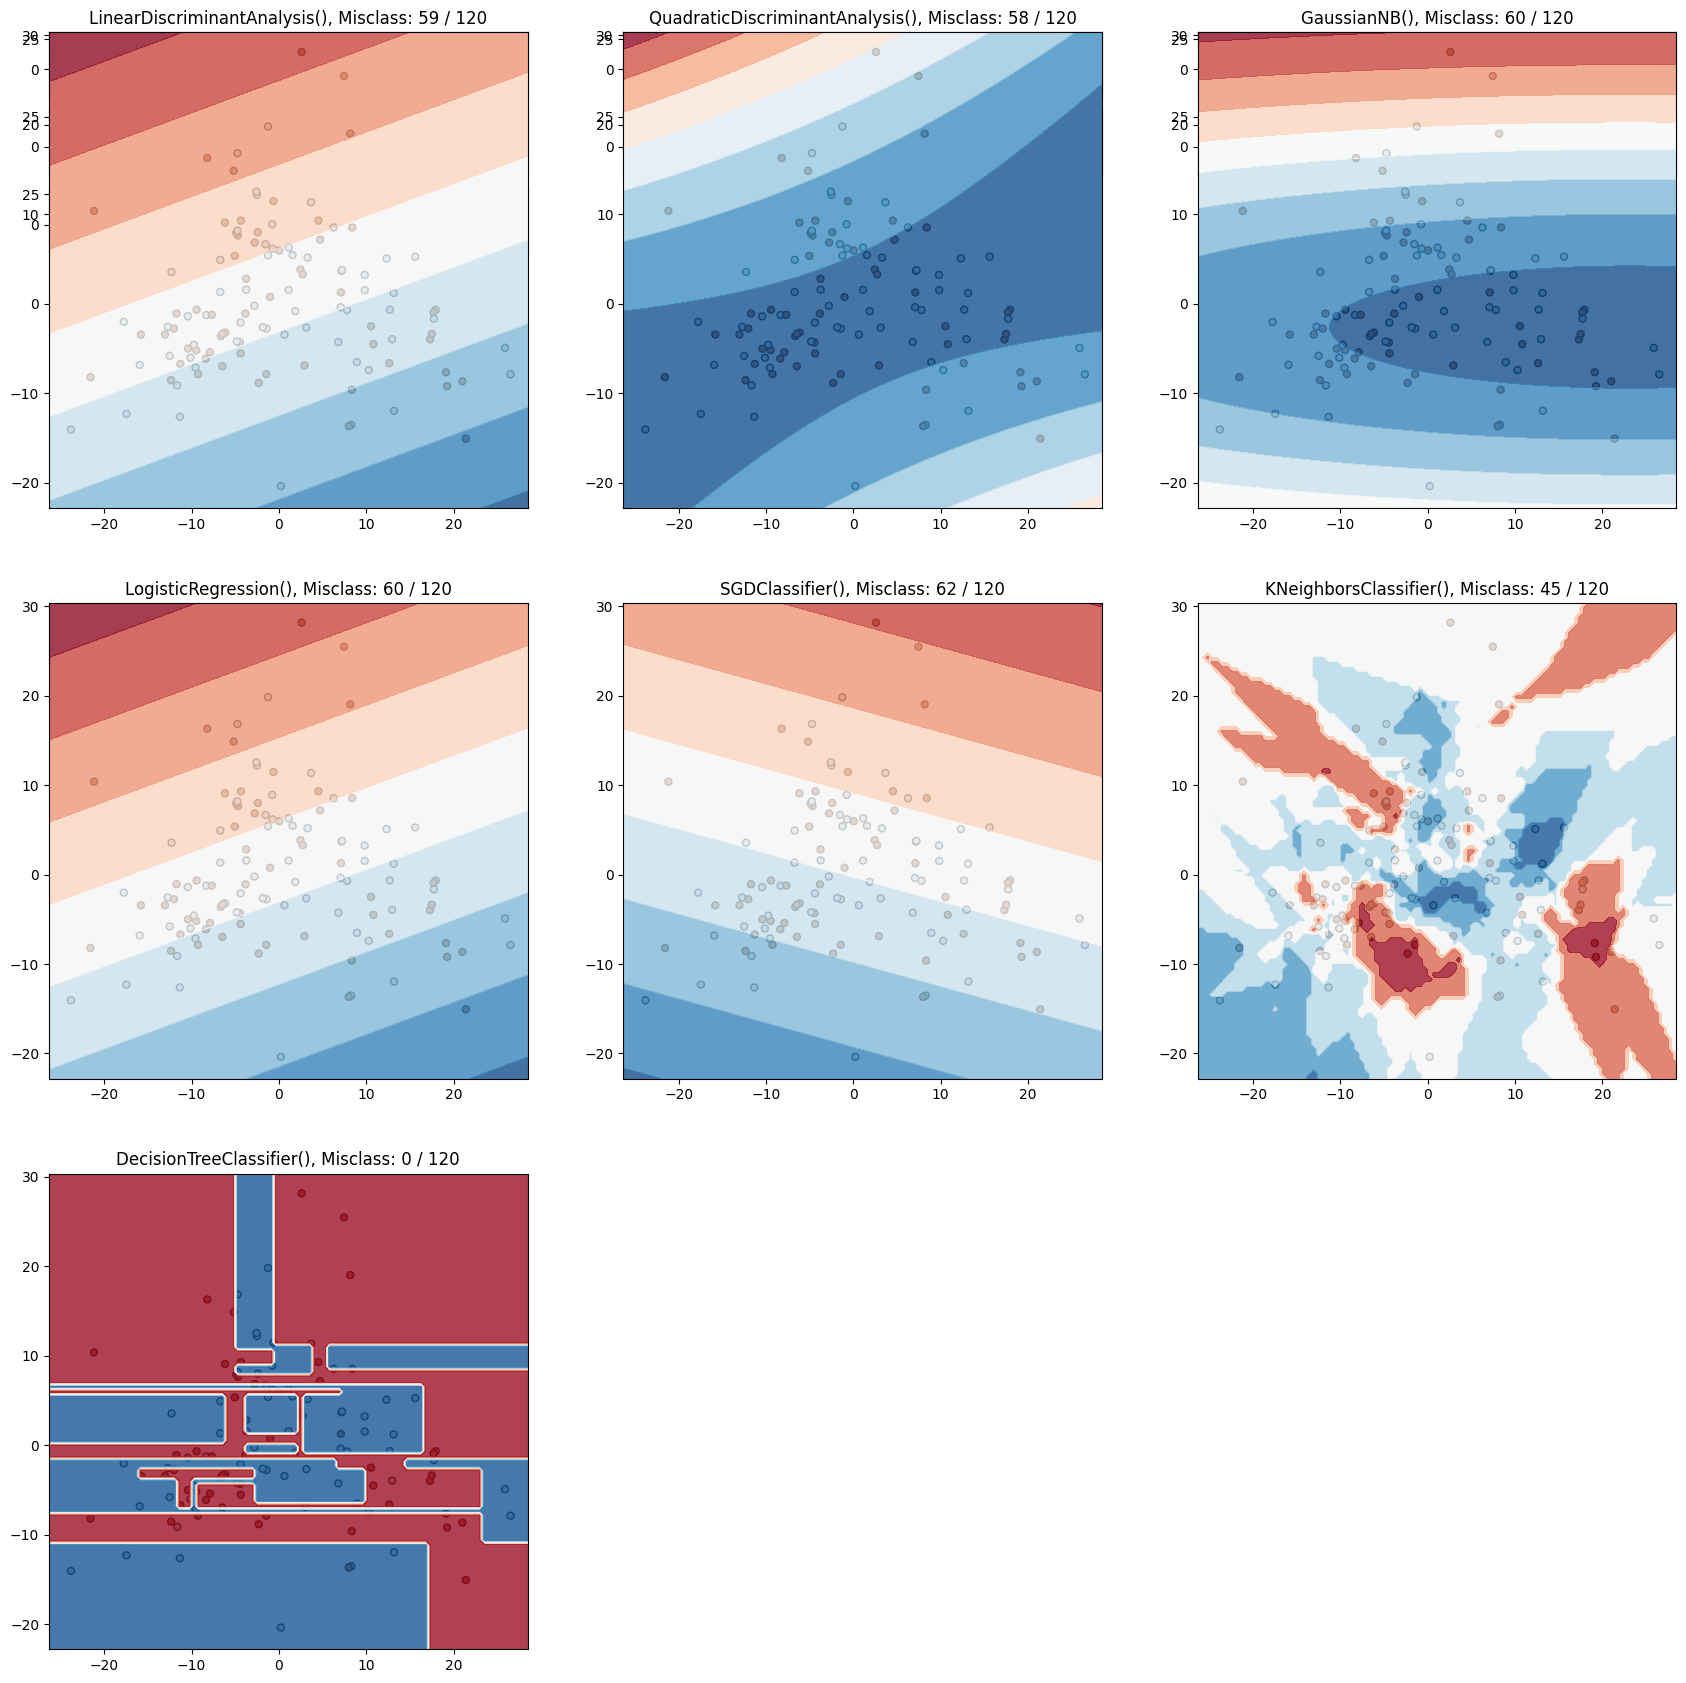

In [8]:
# Plot several basic classifiers and plot the result. Define misclasses
clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier()]
Xs = X_train_pca
Ys = y_train_list
clfs_fit = list()

# First make a plot without classifiers:
fig = plt.figure(figsize=(21,3*len(clsfs)))
num = 0  # Iteration number for the subplots

for num in range(0,7):
    ax = fig.add_subplot(21, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)


# Fit the classifiers and add them to the plot
num=0
Xt=list()
Yt=list()
for clf in clsfs:
    # Fit classifier
    clf.fit(Xs,Ys)
    y_pred=clf.predict(Xs)
    # Predict labels using fitted classifier

    # Make scatterplot of features
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:,0], Xs[:,1])
    # Add overlay through colorplot function
    t=(f"{clf}, Misclass: %d / %d" % ((Ys!=y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num+=1

    clfs_fit.append(clf)
    Xt.append(Xs)
    Yt.append(Ys)


**KNN**

In [17]:
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation

# Specify the classifier
knn = neighbors.KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {
    "n_neighbors": list(range(1, 26, 2))
}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method, use area under ROC curve as scoring metric
# Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')

# Do the entire search
grid_search.fit(X_train_scaled, y_train['label'].values)

# Show the complete results of the cross validation
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000954,0.000214,0.005349,0.003102,1,{'n_neighbors': 1},0.833333,0.833333,0.500000,0.333333,0.750000,0.416667,0.916667,0.583333,0.583333,0.657143,0.640714,0.182656,5
1,0.000998,0.000146,0.012777,0.013596,3,{'n_neighbors': 3},0.875000,0.958333,0.708333,0.722222,0.750000,0.305556,0.861111,0.652778,0.541667,0.771429,0.714643,0.176699,1
2,0.000945,0.000085,0.009143,0.008600,5,{'n_neighbors': 5},0.833333,0.888889,0.750000,0.500000,0.736111,0.333333,0.972222,0.638889,0.555556,0.785714,0.699405,0.183780,2
3,0.001103,0.000320,0.008101,0.010250,7,{'n_neighbors': 7},0.638889,0.902778,0.666667,0.416667,0.722222,0.347222,0.930556,0.694444,0.680556,0.700000,0.670000,0.171975,3
4,0.000988,0.000179,0.015261,0.021492,9,{'n_neighbors': 9},0.694444,0.916667,0.694444,0.527778,0.625000,0.375000,0.888889,0.583333,0.569444,0.800000,0.667500,0.159276,4
5,0.000918,0.000097,0.005219,0.002484,11,{'n_neighbors': 11},0.597222,0.875000,0.597222,0.416667,0.472222,0.513889,0.736111,0.722222,0.625000,0.757143,0.631270,0.134907,6
6,0.001022,0.000112,0.007948,0.006262,13,{'n_neighbors': 13},0.666667,0.847222,0.611111,0.388889,0.430556,0.527778,0.680556,0.652778,0.638889,0.800000,0.624444,0.137475,7
7,0.000937,0.000118,0.014469,0.017926,15,{'n_neighbors': 15},0.652778,0.791667,0.555556,0.347222,0.375000,0.500000,0.750000,0.791667,0.625000,0.742857,0.613175,0.156382,9
8,0.001756,0.001651,0.017768,0.024199,17,{'n_neighbors': 17},0.694444,0.819444,0.458333,0.305556,0.416667,0.597222,0.777778,0.708333,0.583333,0.757143,0.611825,0.162596,10
9,0.000757,0.000028,0.002603,0.000068,19,{'n_neighbors': 19},0.791667,0.819444,0.500000,0.388889,0.416667,0.666667,0.722222,0.638889,0.527778,0.742857,0.621508,0.146617,8


In [27]:
print(X_test_scaled.shape[0])
print(y_test.shape[0])

37
37


Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
Best classifier: k=9
The optimal N=9
uniform


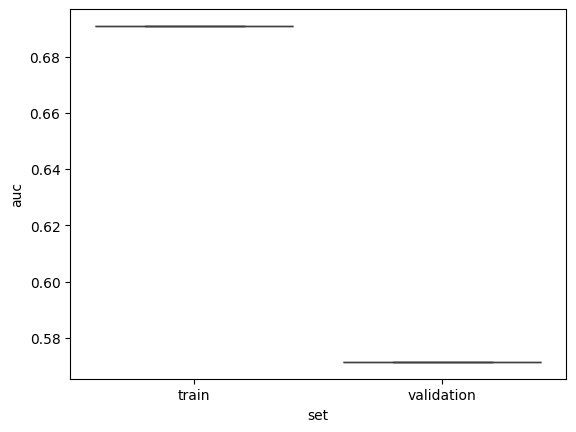

In [44]:
# # Fit kNN
# knn = neighbors.KNeighborsClassifier(n_neighbors=15)
# knn.fit(X_train_pca, y_train)
# score_train = knn.score(X_train_pca, y_train)
# score_test = knn.score(X_test_pca, y_test)

# # Print result
# print(f"Training result simple knn: {score_train}")
# print(f"Test result simple knn: {score_test}")

#### Choose n_neighbors

## Perform grid search in a cross-validation setting
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X, y):
    # # Split the data properly
    # X_validation = X_train_scaled
    # y_validation = y_train['label'].values

    # X_test = X_val_scaled
    # y_test = y_val['label'].values

    # Assign the data properly
    X_train = X_train_pca
    y_train = y_train

    X_validation = X_val_pca
    y_validation = y_val['label'].values



    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train)
    scores = probabilities[:, 1]

    # Get the auc
    auc = metrics.roc_auc_score(y_train, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'train'
    })

    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]

    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })

# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}") ## Weight


#### Choose weights
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Define the parameter grid
param_grid = {
    'weights': ['uniform', 'distance']
}

# Create a kNN classifier
# divide train and test set
X_train = X_train_pca
y_train = y_train

X_validation = X_val_pca
y_validation = y_val['label'].values

knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameter(s)
best_weights = grid_search.best_params_['weights']
print(best_weights)


In [47]:
# Define parameter grid
param_grid = {
    'n_neighbors': list(range(1, 26, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['brute', 'ball_tree', 'kd_tree']
}

# Initialize a kNN classifier
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train_pca, y_train)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Re-train the model with the best parameters
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = best_knn.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

## Visualize results
# Convert the grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Focus on relevant columns
relevant_columns = ['param_n_neighbors', 'param_weights', 'mean_test_score']
results_df = results_df[relevant_columns]
print(results_df)
# Pivot the DataFrame to create a matrix-like format where rows are n_neighbors, columns are weights, and values are mean_test_score
pivot_table = results_df.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')

# Create the heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(pivot_table, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
plt.title('k-NN Hyperparameter Optimization Results')
plt.xlabel('Weights')
plt.ylabel('Number of Neighbors (n_neighbors)')
plt.show()


Best parameters: {'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'uniform'}
Validation Accuracy: 0.6551724137931034
   param_n_neighbors param_weights  mean_test_score
0                  1       uniform         0.476905
1                  1      distance         0.476905
2                  3       uniform         0.486508
3                  3      distance         0.496468
4                  5       uniform         0.533810
..               ...           ...              ...
73                21      distance         0.493571
74                23       uniform         0.417024
75                23      distance         0.490794
76                25       uniform         0.411429
77                25      distance         0.487937

[78 rows x 3 columns]


ValueError: Index contains duplicate entries, cannot reshape